[문제2] 디스크의 폴더(fruits)에 열가지 종류의 과일 저장된 이미지 파일 활용 데이
터 증강 및 CNN 모델 작성 및 이미지 분류
1) GPU 사용을 위한 ‘cuda’device로 설정한다.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
torch.manual_seed(111)
IMAGE_SIZE = 128
FULL_BATCH = 2301
TRAIN_BATCH = 100
AUGMENT_N=1000
learning_rate = 0.001
epochs = 10

In [3]:

device='cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
  torch.cuda.manual_seed_all(111)
print(device)

cpu


2) fruits’폴더에 저장된 원본 이미지 파일 전체를 데이터 셋으로 생성한다.


In [4]:
train_tf = transforms.Compose([
           transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
           transforms.ToTensor(),
           ])

test_tf = transforms.Compose([
          transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
          transforms.ToTensor(),
          ])

In [5]:
train_dir = "../data00/fruits_data/train"
test_dir = "../data00/fruits_data/test"

In [6]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_tf)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=test_tf)

In [7]:
print(train_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 2301
    Root location: ../data00/fruits_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 1025
    Root location: ../data00/fruits_data/test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


폴더명 이름 통일 후 확인

In [8]:
print("Train classes:")
print(len(train_dataset.classes), train_dataset.classes)
print(train_dataset.class_to_idx)

print("\nTest classes:")
print(len(test_dataset.classes), test_dataset.classes)
print(test_dataset.class_to_idx)


Train classes:
10 ['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']
{'apple': 0, 'avocado': 1, 'banana': 2, 'cherry': 3, 'kiwi': 4, 'mango': 5, 'orange': 6, 'pinenapple': 7, 'strawberries': 8, 'watermelon': 9}

Test classes:
10 ['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'stawberries', 'watermelon']
{'apple': 0, 'avocado': 1, 'banana': 2, 'cherry': 3, 'kiwi': 4, 'mango': 5, 'orange': 6, 'pinenapple': 7, 'stawberries': 8, 'watermelon': 9}


In [9]:
train_loader = DataLoader(train_dataset, 
                          batch_size=FULL_BATCH,
                          shuffle=True)
                          
test_loader  = DataLoader(test_dataset,  
                          batch_size=FULL_BATCH, 
                          shuffle=False)

test_loader_shuffled = DataLoader(test_dataset,
                                batch_size=32,
                                shuffle=True
)


잘 나눠졌는지 확인하는 코드

In [10]:
print(train_dataset.samples[0])  # (파일경로, 라벨)
print(test_dataset.samples[0])

('../data00/fruits_data/train\\apple\\images.jpeg', 0)
('../data00/fruits_data/test\\apple\\img_1001.jpeg', 0)


3) 로드된 이미지 데이터셋의 이미지와 레이블을 10개만 출력하여 데이터를 확인한다.


In [11]:
images, labels=next(iter(train_loader)) #1배치 꺼내기
print(labels)

tensor([2, 0, 0,  ..., 8, 7, 5])


In [12]:
images1, labels1=next(iter(test_loader)) #1배치 꺼내기
print(labels1)

tensor([0, 0, 0,  ..., 9, 9, 9])


In [13]:
images.size() #([2301, 3, 128, 128]) 전체, 3채널, 128, 128 크기

torch.Size([2301, 3, 128, 128])

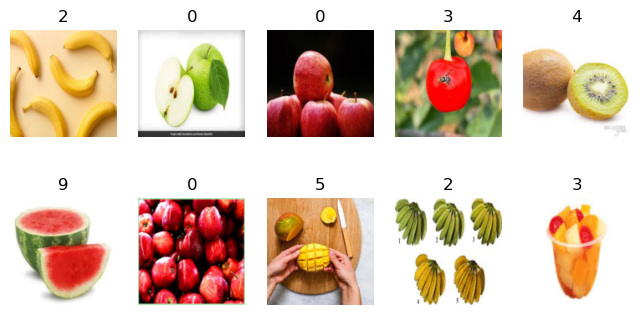

In [14]:
def plot(x, y):
  plt.figure(figsize=(8,4))
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(y[i].item()) #tensor니까 item
    plt.imshow(x[i].permute(1,2,0)) #텐서(chanel, row, col) 그림은 aray로.:배열(row, col, channel)
    plt.axis('off')
  plt.show()

plot(images, labels)

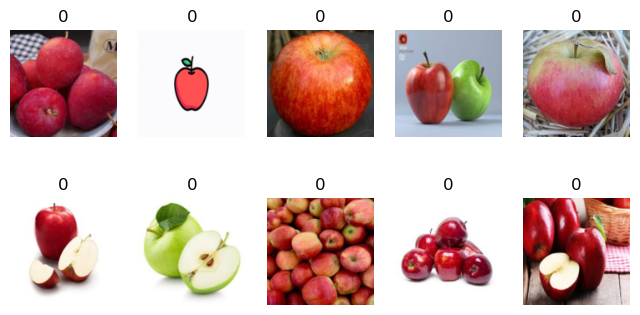

In [15]:
def plot(x, y):
  plt.figure(figsize=(8,4))
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(y[i].item()) #tensor니까 item
    plt.imshow(x[i].permute(1,2,0)) #텐서(chanel, row, col) 그림은 aray로.:배열(row, col, channel)
    plt.axis('off')
  plt.show()

plot(images1, labels1)

4) 이미지 증강(확대, 회전, 이동, 색상(대비, 밝기, 채도) 등)을 수행하여 데이터 셋
에 추가한다.


In [16]:
X = images
Y = labels

print(X.size(), Y.size())

torch.Size([2301, 3, 128, 128]) torch.Size([2301])


In [17]:
Y==0

tensor([False,  True,  True,  ..., False, False, False])

In [18]:
(Y==0).sum()

tensor(230)

In [19]:
next(iter(train_loader))

[tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
          [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
          [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.00

다음 배치를 images와 laber 전체를 보고싶으면
next(iter(train_loader)) 사용.

이미지증강_확대

In [20]:
image_trasform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

In [21]:
transform_dataset = ImageFolder(root='../data00/fruits_data/train',
                                transform=image_trasform)
transforms_loader=DataLoader(transform_dataset,
                            batch_size=AUGMENT_N,
                            shuffle=True,
                            num_workers=1)                                


In [22]:
transform_images, labels=next(iter(transforms_loader))

In [23]:
def plot(x, y):
  plt.figure(figsize=(8,10))
  for i in range(len(x)):
    plt.subplot(5,5,i+1)
    plt.title(y[i].item()) #tensor니까 item
    plt.imshow(x[i].permute(1,2,0)) #텐서(chanel, row, col) 그림을 그릴때는 aray로 있어야해.:배열(row, col, channel)
    plt.axis('off')
  plt.show()

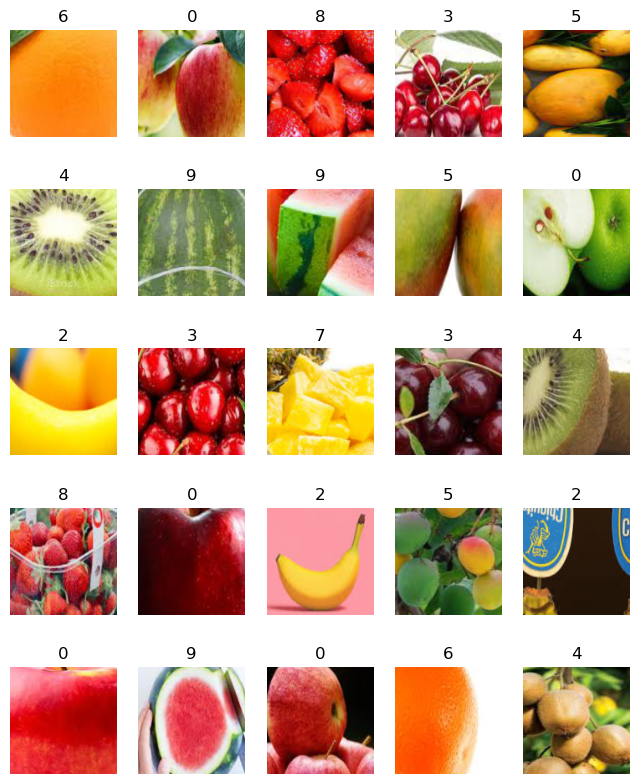

In [24]:
plot(transform_images[:25], labels[:25])

In [25]:
print(transform_images.size(), labels.size())

torch.Size([1000, 3, 128, 128]) torch.Size([1000])


In [26]:
X1=torch.cat([X, transform_images],dim=0)
Y1=torch.cat([Y, labels], dim=0)
print(X1.size(), Y1.size())

torch.Size([3301, 3, 128, 128]) torch.Size([3301])


이미지증강_회전

In [27]:
def create_loader(transform):
    transform_dataset = ImageFolder(root='../data00/fruits_data/train',
                                    transform=image_trasform)
    transforms_loader=DataLoader(transform_dataset,
                                batch_size=AUGMENT_N,
                                shuffle=True,
                                num_workers=1)

    transform_images, labels = next(iter(transforms_loader))

    plot(transform_images[:25], labels[:25])

    return transform_images, labels


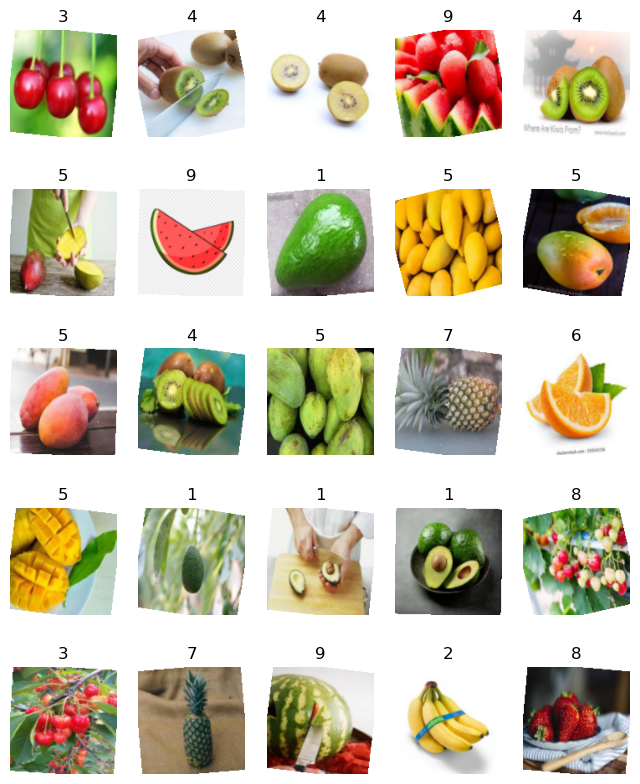

torch.Size([4301, 3, 128, 128]) torch.Size([4301])


In [28]:
image_trasform=transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),

    transforms.RandomRotation(degrees=(-15, 15),
                            interpolation=transforms.InterpolationMode.BILINEAR, fill=255),
    transforms.ToTensor()                           
])

rot_tf_images, rot_tf_labels=create_loader(image_trasform)
X2=torch.cat([X1, rot_tf_images], dim=0)
Y2=torch.cat([Y1, rot_tf_labels], dim=0)
print(X2.size(), Y2.size())

이미지증강_이동

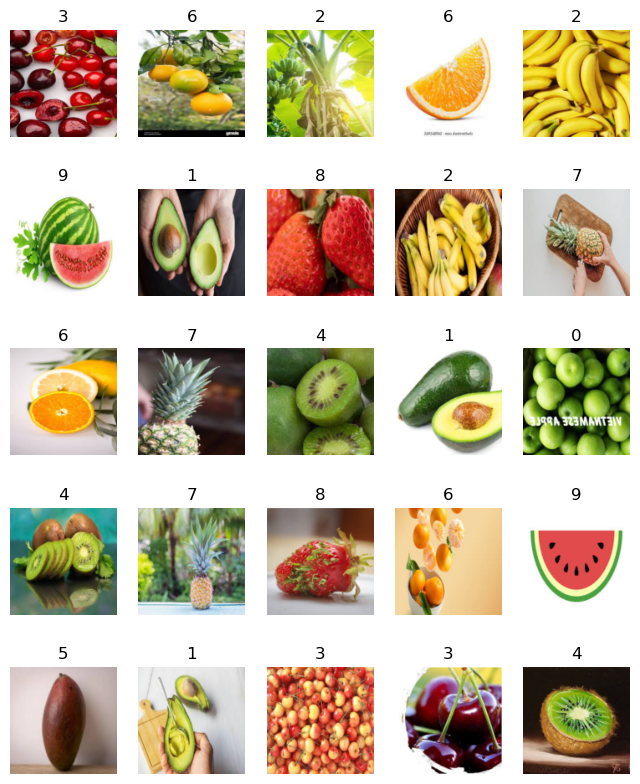

torch.Size([5301, 3, 128, 128]) torch.Size([5301])


In [29]:
image_trasform=transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),

    transforms.RandomHorizontalFlip(p=0.8),
    transforms.ToTensor()
])

flip_tf_images, flip_tf_labels=create_loader(image_trasform)
X3=torch.cat([X2, flip_tf_images], dim=0)
Y3=torch.cat([Y2, flip_tf_labels], dim=0)
print(X3.size(), Y3.size())

이미지증강_색상

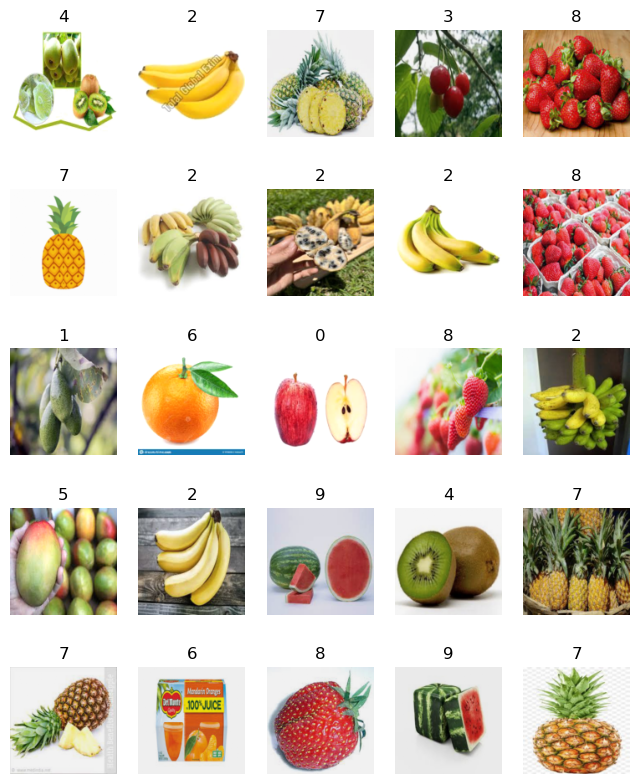

torch.Size([6301, 3, 128, 128]) torch.Size([6301])


In [30]:
image_trasform=transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),

    transforms.ColorJitter(brightness=(0.9, 1.1),
                          contrast=(1,1),
                          saturation=(0.8, 1.0)),
    transforms.ToTensor()
])

color_tf_images, color_th_labels=create_loader(image_trasform)
X4=torch.cat([X3, color_tf_images], dim=0)
Y4=torch.cat([Y3, color_th_labels], dim=0)
print(X4.size(), Y4.size())

5) 4)에서 생성된 데이터 셋을 훈련 데이터와 테스트 데이터로 나눈다.

이미 폴더로 나눠져있음.

6) 훈련 데이터 셋을 한 번에 100씩 로드 되도록 train_loader을 생성한다

In [31]:
train_aug_dataset = TensorDataset(X4, Y4)
train_aug_loader = DataLoader(train_aug_dataset, batch_size=TRAIN_BATCH, shuffle=True)

print(len(train_aug_dataset))

6301


In [32]:
print(train_aug_dataset.tensors[0].shape)  # X 텐서
print(train_aug_dataset.tensors[1].shape)  # y 텐서

torch.Size([6301, 3, 128, 128])
torch.Size([6301])


In [33]:
print(train_aug_dataset)


In [34]:
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 1025
    Root location: ../data00/fruits_data/test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


7) CNN 모델 정의 및 수행을 위한 클래스를 작성하고 모델을 생성한다.


In [35]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__() 

    self.layer1= nn.Sequential(
      nn.Conv2d(3, 8, 3, padding=1), 
      nn.ReLU(),
      # nn.Dropout(0.25), 딥러닝 선의 25% 날려. 오버피팅 방지
      # nn.BatchNorm2d() 정규화도 가능, 1D든 2D든
      nn.MaxPool2d(kernel_size=2, stride=2) # 64*64
    )

    self.layer2= nn.Sequential(
      nn.Conv2d(8, 16, 3, padding=1), 
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2) # 32*32
    )

    self.layer3= nn.Sequential(
      nn.Conv2d(16, 32, 3, padding=1), 
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2) #16*16
    )

    self.layer4= nn.Sequential(
      nn.Conv2d(32, 64, 3, padding=1), 
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2) #64*8*8
    )

    self.layer5= nn.Sequential(
      nn.Conv2d(64, 128, 3, padding=1), 
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2) # 128*4*4 만큼 특징이 있다.
    )


    #완전 연결층

    self.fc1=nn.Linear(128*4*4, 128) #128은 내 맘대로, 은닉층의 수는 모델개발자가 선택
    self.fc2=nn.Linear(128, 64)
    self.fc3=nn.Linear(64,10)

  def forward(self, x): #파이썬의 함수는 항상 self가 들어온다
    x=self.layer1(x)
    x=self.layer2(x)
    x=self.layer3(x)
    x=self.layer4(x)
    x=self.layer5(x)


    #컨볼루션 층 끝!

#3차원 이미지
    x=x.view(x.size(0), -1)
    x=self.fc1(x)
    x=self.fc2(x)
    x=self.fc3(x)
#소프트맥스에 넣어줘야하지만 crossentropy에 넣을 거라서 바로 리턴

    return x
      



8) 10가지 과일 종류 분류에 적절한 비용함수를 선택하고, 비용함수 최소화 함수는 
Adam을 사용한다.


In [36]:
model=CNN().to(device)
optimizer=optim.Adam(model.parameters()) 
crit=nn.CrossEntropyLoss().to(device)

9) 훈련 데이터를 사용하여 모델을 학습시키고 테스트 데이터를 사용하여 모델의 정확
도를 확인하면서 CNN 모델을 학습시킨다.


In [37]:
def train(model, train_aug_loader, optimizer, epoch):
  model.train()
  total_loss = 0.0
  correct = 0
  total = 0

  for batch_index,(img, label) in enumerate(train_aug_loader):
    img = img.to(device) 
    label=label.to(device)

    optimizer.zero_grad()
    y_hat=model(img) 
    loss=crit(y_hat, label) #결과와 라벨로 손실함수 구하고
    loss.backward()
    optimizer.step() #wb를 업데이트

    total_loss += loss.item() * img.size(0)
    pred = y_hat.argmax(dim=1)
    correct += (pred == label).sum().item()
    total += img.size(0)

    if batch_index%10==0: 
      print(f'train index/epoch:{batch_index,epoch}, train Loss:{loss.item()}') 

  avg_loss = total_loss / total
  avg_acc  = correct / total * 100
  return avg_loss, avg_acc    


In [38]:
def evaluate(model, test_loader):
  model.eval() #drop out 안써. 만약에 쓴다면 
  test_loss = 0
  correct = 0
  total = 0

  with torch.no_grad(): #손실함수 기울기 연산 금지
    for img, label in test_loader:
        img=img.to(device)
        label=label.to(device)

        y_hat=model(img)
        test_loss+=crit(y_hat, label).item() * img.size(0) # test 손실함수를 구해서 같이 출력

        pred=y_hat.argmax(dim=-1) #한 행에 5개의 값이 나와. 가장 큰 값을 구해서 pred, 1을 하던 -1하던 상관 없어
        correct+=(pred==label).sum() #True 1 or False 0 sum하면 맞는 갯수가 구해짐
        total += img.size(0)

  test_loss=test_loss/total
  test_accuracy = correct/total*100 
  return test_loss, test_accuracy

10) 학습할 때 검증데이터를 사용하여 검증데이터의 손실함수가 최소일 때 모델을 저
장하고, 최소 값을 찾은 후 50 epoch 증가할 때 검증데이터 손실함수가 감소하지 않으
면 종료한다.


In [39]:
from copy import deepcopy

epochs = 200
early_stop=50 
lowest_loss=np.inf
lowest_epoch=np.inf
best_model=None

path="../data00/model.pt" 

In [40]:
test_losses = []
test_accs = []

In [41]:
for epoch in range(epochs):
  train(model, train_aug_loader, optimizer, epoch)

  test_loss, test_accuracy=evaluate(model, test_loader) 
  
  test_losses.append(test_loss)
  test_accs.append(float(test_accuracy))   

  print(f'epoch:{epoch}, test loss:{test_loss}, test_accuracy:{test_accuracy}')
 
  #얼리스탑

  if test_loss < lowest_loss:
    lowest_loss=test_loss
    lowest_epoch=epoch 
    best_model=deepcopy(model) 
    torch.save(model.state_dict(), path) #딴 파일에서 쓰고 싶으면 저장

  else:
    if early_stop >0 and lowest_epoch + early_stop<epoch: #테스트의 최소cost를 
      print(f'{lowest_epoch} 이후에 {early_stop} 증가되는 동안 손실함수 감소가 없음')
      break

print(f'{lowest_epoch}일 때 손실함수의 값이 {lowest_loss}로 가장 낮음')

train index/epoch:(0, 0), train Loss:2.309417247772217
train index/epoch:(10, 0), train Loss:2.304004430770874
train index/epoch:(20, 0), train Loss:2.3034508228302
train index/epoch:(30, 0), train Loss:2.297027349472046
train index/epoch:(40, 0), train Loss:2.1806232929229736
train index/epoch:(50, 0), train Loss:2.1156692504882812
train index/epoch:(60, 0), train Loss:1.968050479888916
epoch:0, test loss:1.9791910648345947, test_accuracy:24.975608825683594
train index/epoch:(0, 1), train Loss:2.00496768951416
train index/epoch:(10, 1), train Loss:1.8133807182312012
train index/epoch:(20, 1), train Loss:1.9005253314971924
train index/epoch:(30, 1), train Loss:1.7934937477111816
train index/epoch:(40, 1), train Loss:1.7761136293411255
train index/epoch:(50, 1), train Loss:1.6185412406921387
train index/epoch:(60, 1), train Loss:1.7775799036026
epoch:1, test loss:1.8883532285690308, test_accuracy:27.512195587158203
train index/epoch:(0, 2), train Loss:1.9121475219726562
train index/epoc

11) 훈련 데이터의 손실함수와 검증데이터의 손실함수를 저장하여 차트를 작성한다. 


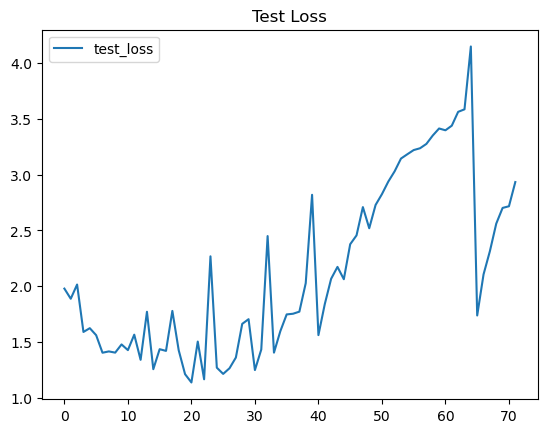

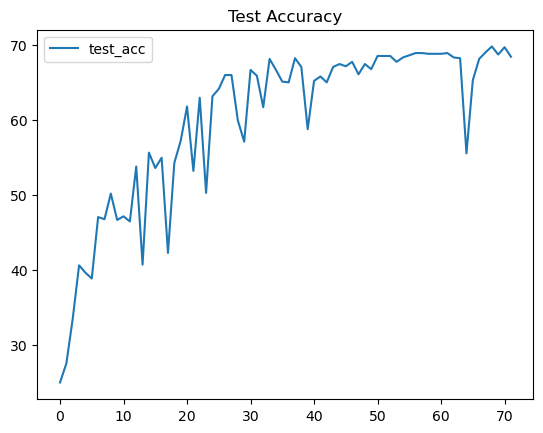

In [42]:

plt.figure()
plt.plot(test_losses, label="test_loss")
plt.legend()
plt.title("Test Loss")
plt.show()

plt.figure()
plt.plot(test_accs, label="test_acc")
plt.legend()
plt.title("Test Accuracy")
plt.show()


12) 학습된 모델을 사용하여 이미지 분류를 수행하고 이미지와 결과를 출력한다.


In [46]:
model2 = CNN().to(device)

state = torch.load(path, map_location=device)   # OrderedDict = state_dict
model2.load_state_dict(state)

model2.eval()
print("model2 loaded (state_dict).")


model2 loaded (state_dict).


In [47]:
model2.eval()
correct, total = 0, 0

with torch.no_grad():
    for x, y in test_loader:   # shuffle=False 평가용
        x, y = x.to(device), y.to(device)
        pred = model2(x).argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

print("Test Accuracy:", correct/total)

Test Accuracy: 0.6175609756097561


pred: [2 1 1 1 7 4 7 0 8 6]
true: [2 4 2 5 7 1 5 0 9 6]


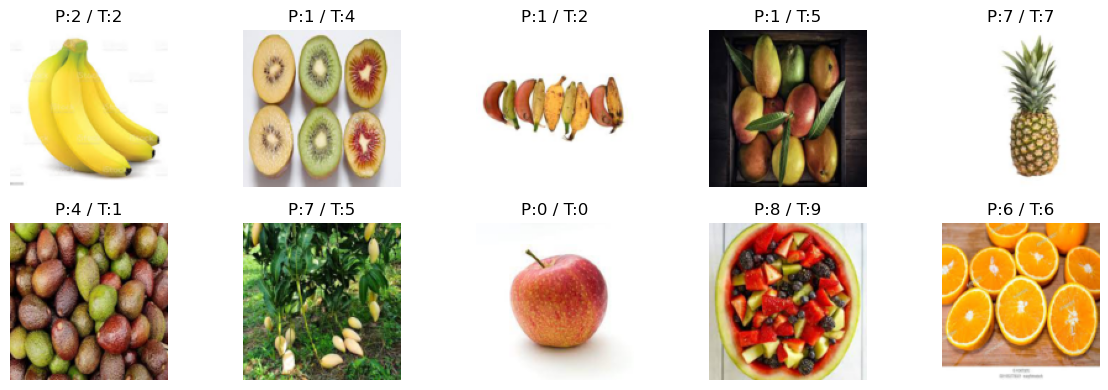

In [48]:

images, labels = next(iter(test_loader_shuffled))
images, labels = images.to(device), labels.to(device)


n = 10
images_small = images[:n]
labels_small = labels[:n]

with torch.no_grad():
    preds_small = model2(images_small).argmax(dim=1)

print("pred:", preds_small.detach().cpu().numpy())
print("true:", labels_small.detach().cpu().numpy())


plt.figure(figsize=(12,4))
for i in range(n):
    plt.subplot(2, 5, i+1)
    img = images_small[i].detach().cpu().permute(1,2,0)  # (C,H,W)->(H,W,C)

    plt.imshow(img)
    plt.title(f"P:{preds_small[i].item()} / T:{labels_small[i].item()}")
    plt.axis("off")
plt.tight_layout()
plt.show()


13) 훈련이 완료된 모델을 상태정보와 함께 저장한다.


In [49]:

from copy import deepcopy

save_path = "../data00/model.pt"   # 네가 쓰던 path 그대로 OK

checkpoint = {
    "model_state_dict": deepcopy(best_model).cpu().state_dict(),  
    # 또는 best_model이 있으면 best_model로!
    
    "lowest_loss": lowest_loss,
    "lowest_epoch": lowest_epoch,
}

torch.save(checkpoint, save_path)
print("모델 저장 완료:", save_path)


모델 저장 완료: ../data00/model.pt


14) 테스트 데이터로 예측을 수행하고 예측결과로 Accuracy를 구하여 출력한다.


In [50]:
model2.eval()
correct, total = 0, 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        pred = model2(x).argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

acc = correct / total
print("Test Accuracy:", acc)

Test Accuracy: 0.6175609756097561


15) 예측결과로 혼동행렬(confusion matrix)를 작성하라.


confusion matrix shape: (10, 10)


<Figure size 800x800 with 0 Axes>

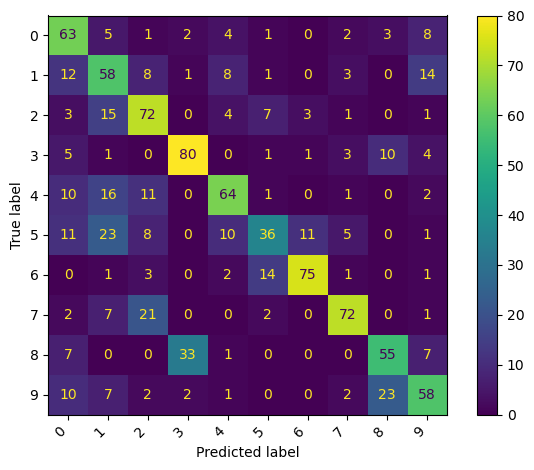

In [51]:

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model2.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        pred = model2(x).argmax(dim=1).detach().cpu().numpy()
        all_preds.append(pred)
        all_labels.append(y.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = confusion_matrix(all_labels, all_preds)
print("confusion matrix shape:", cm.shape)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(8, 8))
disp.plot(values_format='d', cmap=None)  # 색 지정 안 함(기본)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


16) 새로운 ipynb 파일을 작성하여 다음 작업을 수행한다.- 웹에서 새로운 과일 이미지 파일을 저장하여 예측 데이터 셋을 생성한 후 분류
를 위해 로드한다.- 저장된 CNN모델을 상태정보와 device 적용하여 로드한다.- 새로운 생성된 테스트 데이터 셋으로 이미지 분류를 수행한다.